In [21]:
import pandas as pd
import numpy as np
from utils import preprocess
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates

In [38]:
df = pd.read_csv("data/3274-Device-Data-Fix.csv")
df = preprocess.get_clean_df(df)
df["soil_moisture_40"] = df["soil_moisture_40"].astype(np.float64)

In [24]:
df.head()

,date,irrigation_volume_0,irrigation_volume_accumulated_0,soil_moisture_20,soil_moisture_40,soil_moisture_60
0,2023-01-01 00:00:00,0.0,0.0,0.241,0.277,0.159
1,2023-01-01 00:30:00,0.0,0.0,0.241,0.277,0.159
2,2023-01-01 01:00:00,0.0,0.0,0.241,0.277,0.159
3,2023-01-01 01:30:00,0.0,0.0,0.241,0.277,0.159
4,2023-01-01 02:00:00,0.0,0.0,0.241,0.277,0.159


In [ ]:
start_date = pd.to_datetime("2025-04-01")
end_date   = pd.to_datetime("2025-05-10")


df_constricted = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()
values = df_constricted["soil_moisture_40"].to_numpy()

df_constricted['difference'] = np.concat([[np.nan], np.diff(df_constricted['soil_moisture_40'])])
df_constricted['difference2'] = np.concat([[np.nan], np.diff(df_constricted['difference'])])
print(df_constricted['difference2'])

gradient_marker = []
up_found = False
down_found = False

capacitancy_points = []

found = 0
beta = 0.3

#Aconseguim el punt de capacitancia mirant el primer cop que canvia la segona
#derivada de l'humitat despres d'una irrigacio.
for row in df_constricted.iloc[1:].itertuples(index=True):
    dx = abs(row.difference)
    down = row.irrigation_volume_0 == 0
    if not up_found and not down:
        up_found = True
        continue
    if up_found and not down_found and down:
        down_found = True
        value = row.difference2
        found = 0
        continue
    if up_found and down_found:
        prev_value = value
        value = row.difference2
        
        if (prev_value < 0 and value >= 0) and found == 0:
            found += 1
        elif found > 0 and value >= 0:
            found += 1
        else:
            found = 0
            
        if found == 3:
            gradient_marker.append(row.date)
            up_found = False
            down_found = False
            if len(capacitancy_points) > 0:
                capacitancy_points.append((row.date, beta*capacitancy_points[-1][1] + (1 - beta)*row.soil_moisture_40))
            else:
                capacitancy_points.append((row.date, row.soil_moisture_40))
            
capacitancy_frame = pd.DataFrame(capacitancy_points, columns=["date", "capacitancy"])
capacitancy_frame.head()
        

17173      NaN
17174      NaN
17175    0.001
17176   -0.001
17177    0.000
         ...  
19041    0.000
19042   -0.001
19043    0.001
19044   -0.001
19045    0.001
Name: difference2, Length: 1873, dtype: float64


,date,capacitancy
0,2025-04-01 23:00:00,0.33500
1,2025-04-02 21:30:00,0.34200
2,2025-04-03 20:00:00,0.35600
3,2025-04-04 20:00:00,0.35040
4,2025-04-05 18:00:00,0.35992


39


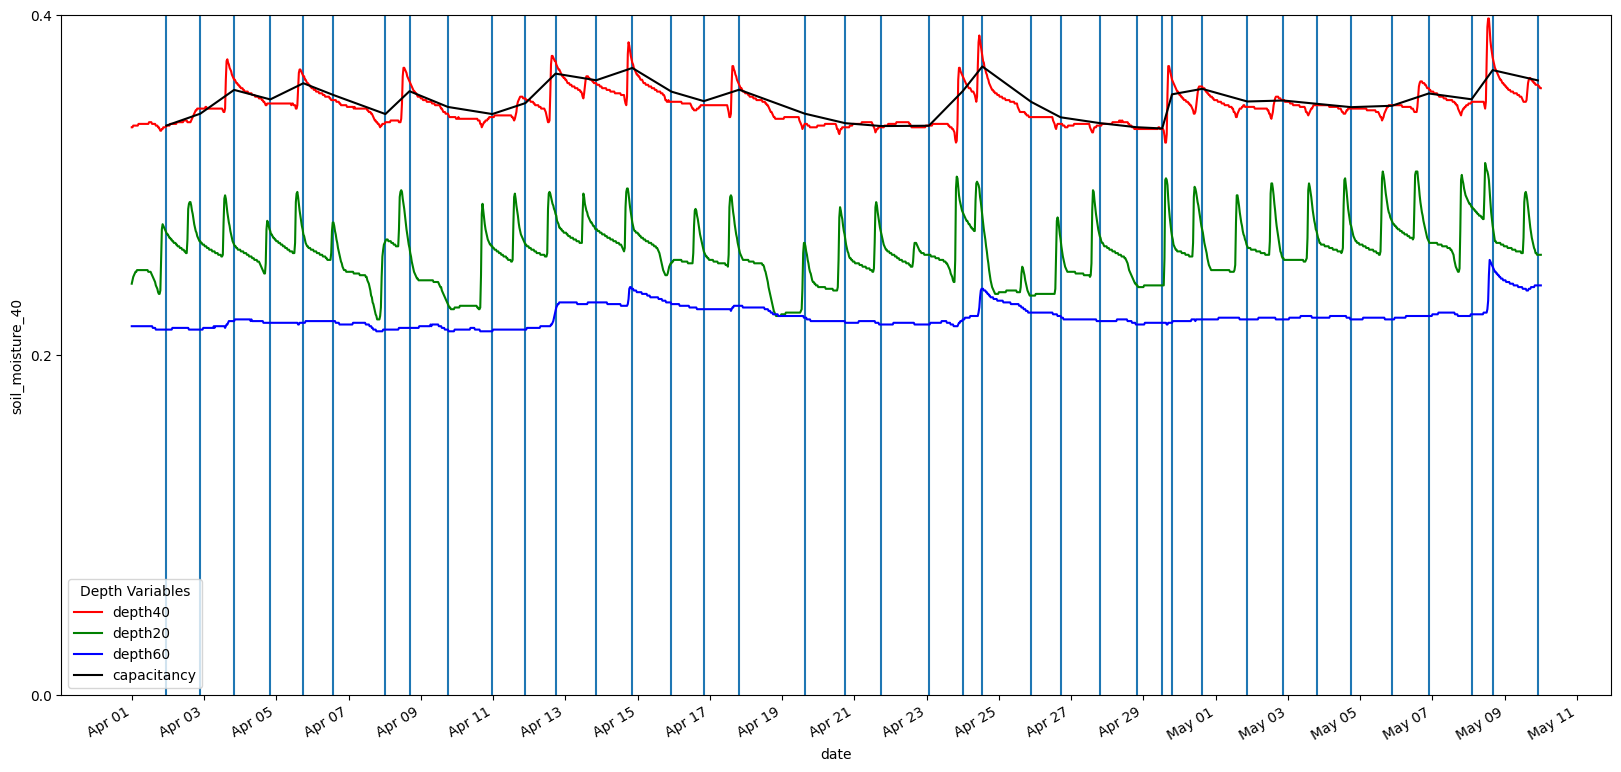

In [57]:
plt.figure(figsize=(20, 10))
print(len(gradient_marker))
for mark in gradient_marker:
    plt.axvline(mark)
sns.lineplot(df_constricted, x="date", y="soil_moisture_40", label="depth40", color="red")
sns.lineplot(df_constricted, x="date", y="soil_moisture_20", label="depth20", color="green")
sns.lineplot(df_constricted, x="date", y="soil_moisture_60", label="depth60", color="blue")
sns.lineplot(capacitancy_frame, x="date", y="capacitancy", label="capacitancy", color="black")
plt.legend(title="Depth Variables")
plt.ylim(0, 0.40)
plt.yticks([0, 0.20, 0.40])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate()  # rotate labels for clarity
plt.show()